# Telco Churn Classification Project

# Importing 

In [1]:
# Our essentials
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#Acquire functions
from acquire import get_connection, new_telco_churn_data, get_telco_churn_data

#Prepare functions
from prepare import num_distributions, clean_telco_churn, telco_churn_split, prep_telco_churn

#Explore functions
from explore import get_obj_stats, countplot, get_churn_heatmap, get_metrics_binary

#sklearn to help us with our machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Acquire Telco_Churn Data

In [5]:
#this acquire function will connect to the database, run a SQL query, & return telco_churn into a usable dataframe
#it will also create a .csv file in our directory.
df = get_telco_churn_data()

# Prepare Telco_Churn Data

In [3]:
#returns joined telco_churn data, just to check.
df.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,3,0030-FNXPP,Female,0,No,No,3,Yes,...,No internet service,No internet service,No internet service,No,19.85,57.2,No,None,Month-to-month,Mailed check
1,2,1,3,0031-PVLZI,Female,0,Yes,Yes,4,Yes,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,1,1,3,0098-BOWSO,Male,0,No,No,27,Yes,...,No internet service,No internet service,No internet service,Yes,19.40,529.8,No,None,Month-to-month,Electronic check
3,1,1,3,0107-WESLM,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,3,1,3,0114-RSRRW,Female,0,Yes,No,10,Yes,...,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


In [4]:
#check data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [6]:
#prep function will split this data into train, validate, and test sets (with our clean data)
train, validate, test = prep_telco_churn(df)

In [7]:
#making sure they have the same amount of columns, while decreasing rows.
train.shape, validate.shape, test.shape

((3943, 27), (1691, 27), (1409, 27))

# Data Exploration

In [5]:
num_vars = ['tenure','monthly_charges','total_charges']
obj_vars = list((df.columns).drop(num_vars))
target = 'churn'

In [6]:
obj_vars

['payment_type_id',
 'contract_type_id',
 'internet_service_type_id',
 'customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'internet_service_type',
 'contract_type',
 'payment_type',
 'is_female']

In [31]:
def get_obj_stats(df):
    for i in obj_vars:
        sns.countplot(data=df, hue=i , x = target) 
        plt.show()

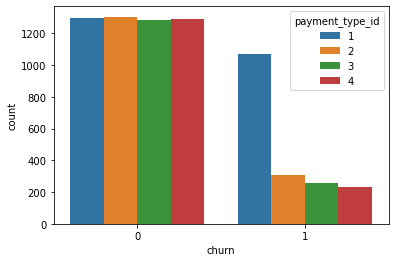

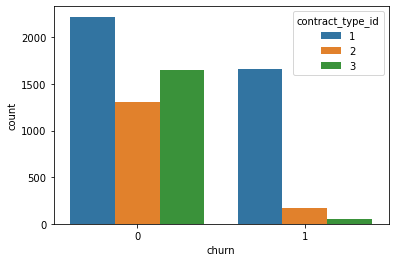

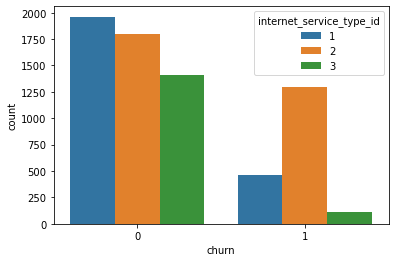

ValueError: Image size of 386x105714 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

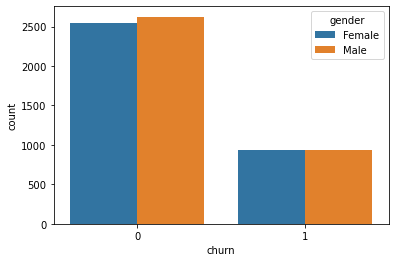

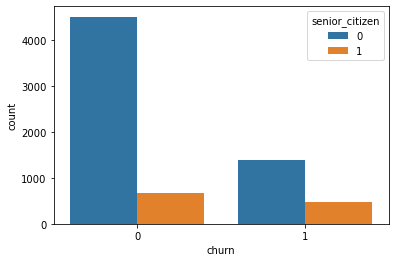

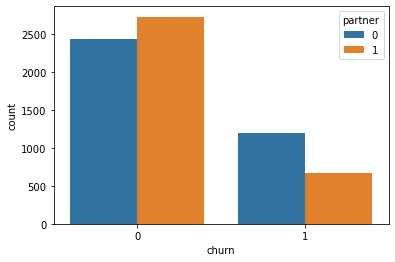

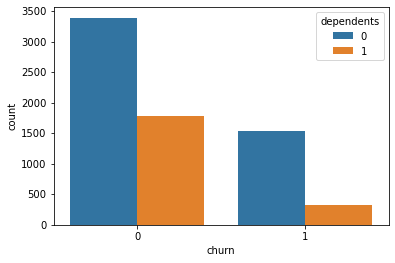

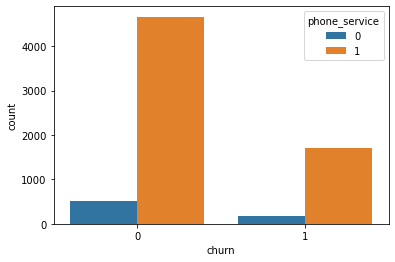

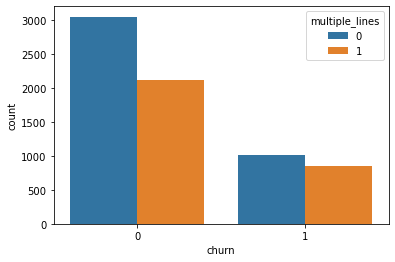

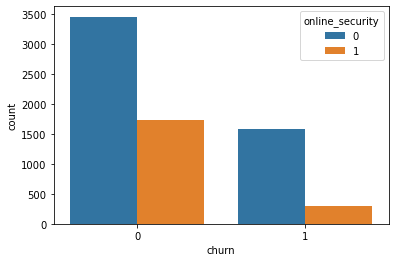

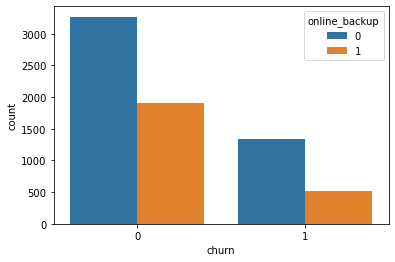

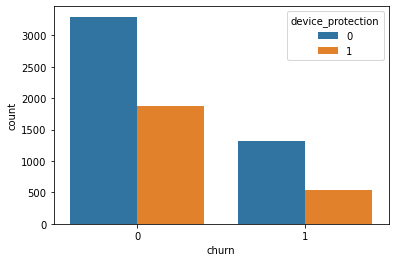

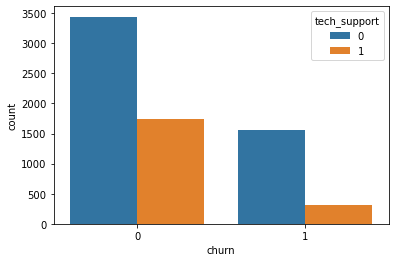

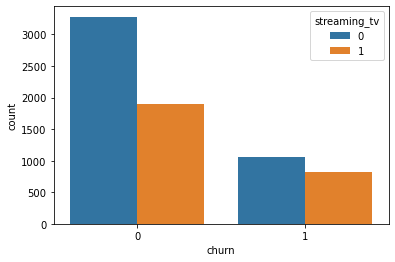

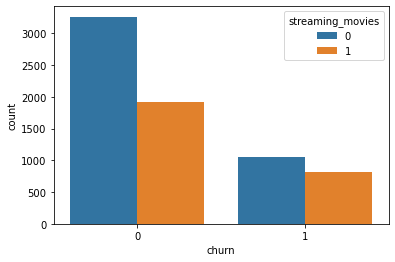

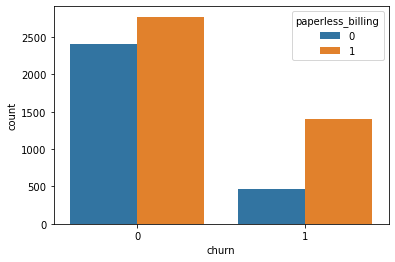

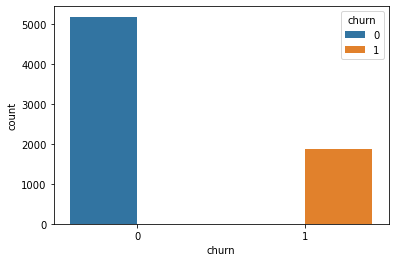

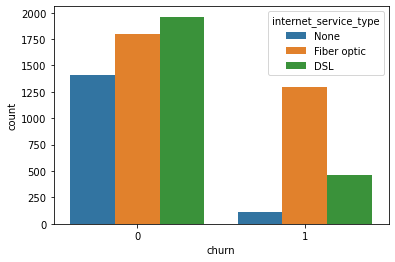

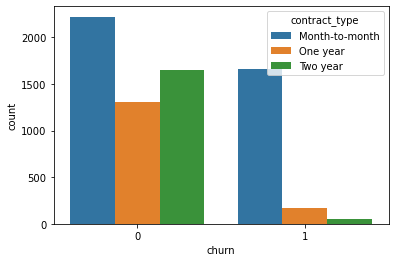

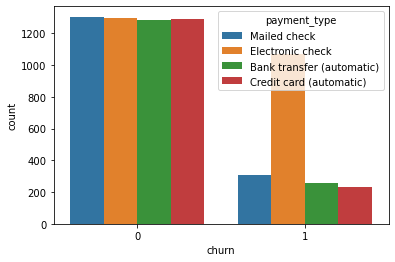

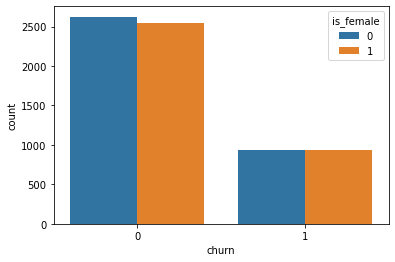

In [32]:
get_obj_stats(df)

### Observations From Large Influx of Count Plots

-I am noticing that customers using fiber optic tend to churn more than other internet service types.

-Monthly customers are the largest churning group of the three contract types. 

-Customers on 2 year contracts tend to stay.

-Customers who pay with electronic check churn more than other payment types.

<AxesSubplot:title={'center':'Features Correlated with Churn'}>

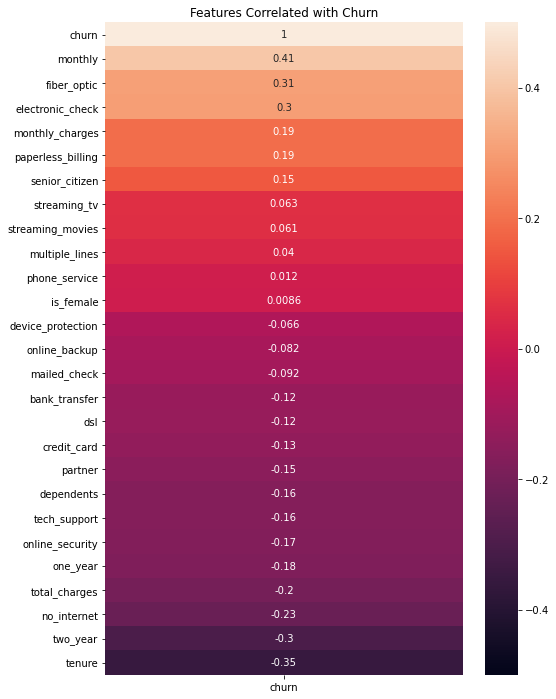

In [16]:
#Heatmaps will show us how much each feature is related to churn.
# -1 being strongest, negatively correlated
# +1 being strongest, positively correlated
get_churn_heatmap(df)

### Observations From Heatmap

- The top of the heatmap represents factors that are the most positively correlated to churn:
    <br>Monthly customers (.41)
    <br>Fiber optic users (.31)
    <br>Electronic check payers (.30)
   

- The bottom of the heatmap represents factors that are most negatively correlated to churn:
    <br> Tenure (-.35)
    <br> Two-year contracts (-.30)

#### Let's run some statistical testing

In [17]:
#Monthly Contracted Customers and Churn

Are they independent?
Is whether or not a customer churns independent of using monthly contracts?

In [86]:
#We are going to use a chi square test, because it compares two categorical variables.

#let's set up a null and alternative hypothesis

null_hypothesis =  "Monthly contracts and churn are independent of each other."
alternative_hypothesis =  "Monthly contracts and churn are not independent of each other."
a = 0.05 #a for alpha 

observed = pd.crosstab(train.monthly, train.churn, margins = True)
observed

churn,0,1,All
monthly,,,
0,1628,127,1755
1,1269,919,2188
All,2897,1046,3943


In [87]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

2.2197565476142607e-129

In [93]:
expected

array([[1289.43317271,  465.56682729, 1755.        ],
       [1607.56682729,  580.43317271, 2188.        ],
       [2897.        , 1046.        , 3943.        ]])

In [92]:
expected[1,1]

580.4331727111337

In [28]:
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Monthly contracts and churn are independent of each other.
There is evidence to suggest: Monthly contracts and churn are not independent of each other.


In [29]:
#Our chi square test is suggesting that churn may be dependent on monthly contracts.

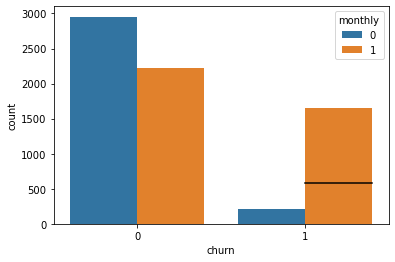

In [94]:
sns.countplot(data=df, hue = 'monthly', x='churn')
plt.axhline(expected[1,1], xmin=.75, xmax=.95, color = 'black')
plt.show()

Takeaways:
 - If contract types were independent to churn, we would only expect 580 monthly customers to leave. However, it is sitting at 919. 
 - Monthly customers are probably more willing to leave since they aren't in any kind of long term commitment. 
 - Price sensitivity, low dissatisfication thresholds.

<br>

In [30]:
#Fiber Optic Users and Churn

In [95]:
null_hypothesis = "Using fiber optic and churning are independent of each other."
alternative_hypothesis = "Using fiber optic and churning are not independent of each other."
a = 0.05 #a for alpha 

observed = pd.crosstab(train.fiber_optic, train.churn, margins = True)
observed

churn,0,1,All
fiber_optic,,,
0,1858,304,2162
1,1039,742,1781
All,2897,1046,3943


In [96]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

2.5087626354447297e-81

In [97]:
expected[1,1]

472.4641136190718

In [33]:
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Using fiber optic and churning are independent of each other.
There is evidence to suggest: Using fiber optic and churning are not independent of each other.


In [34]:
#There's evidence to suggest that customers who use fiber optic and customers who churn are not independent.

<br>

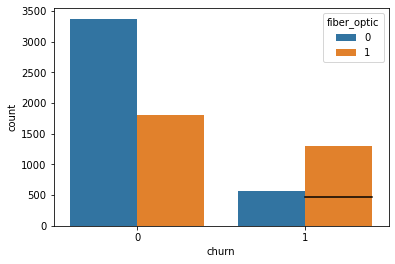

In [98]:
sns.countplot(data=df, hue = 'fiber_optic', x='churn')
plt.axhline(expected[1,1], xmin=.75, xmax=.95, color = 'black')
plt.show()
#black line represents expected churn for fiber optic 

Takeaways:
 - If a customer has fiber optic internet, they are more likely to churn than DSL/no internet.
 - Our expected model only had 472 churned customers with fiber optic, it is actually 742. 
 - Fiber optic was marketed to be able to perform tasks (at a typically higher cost) and customers didn't notice it. 

<br>

In [65]:
#Electronic Checks and Churn

In [99]:
null_hypothesis = "Paying with e-checks and churning are independent of each other."
alternative_hypothesis = "Paying with e-checks and churning are not independent of each other."
a = 0.05 #a for alpha 

observed = pd.crosstab(train.electronic_check, train.churn, margins = True)
observed

churn,0,1,All
electronic_check,,,
0,2173,434,2607
1,724,612,1336
All,2897,1046,3943


In [100]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

3.99605899267811e-82

In [101]:
expected[1,1]

354.4144052751712

In [102]:
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Paying with e-checks and churning are independent of each other.
There is evidence to suggest: Paying with e-checks and churning are not independent of each other.


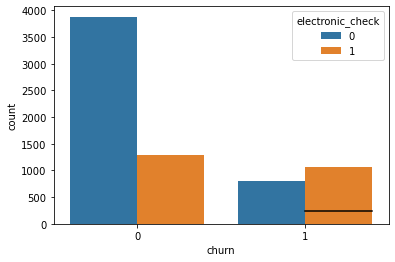

In [111]:
sns.countplot(data=df, hue = 'electronic_check', x='churn')
plt.axhline(expected[1,1], xmin=.75, xmax=.95, color = 'black')
plt.show()

Takeaways:
 - If electronic check and churn were independent, we would expect 354 e-check users to leave. We're actually at 612.
 - It could be that electronic checks are inconvenient (a long process) 

<br>

In [106]:
# Two Year Contracts & Churning

In [107]:
null_hypothesis = "Having a two year contract and churning are independent of each other."
alternative_hypothesis = "Having a two year contract and churning are not independent of each other."
a = 0.05 #a for alpha 

observed = pd.crosstab(train.two_year, train.churn, margins = True)
observed

churn,0,1,All
two_year,,,
0,1999,1022,3021
1,898,24,922
All,2897,1046,3943


In [108]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

3.2123527525742887e-75

In [109]:
expected[1,1]

244.58838447882323

In [110]:
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Having a two year contract and churning are independent of each other.
There is evidence to suggest: Having a two year contract and churning are not independent of each other.


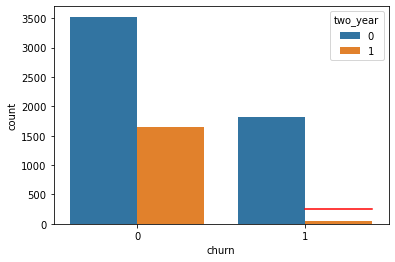

In [113]:
sns.countplot(data=df, hue = 'two_year', x='churn')
plt.axhline(expected[1,1], xmin=.75, xmax=.95, color = 'red')
plt.show()

Takeaways:
 - Customers with two year contracts tend to stay.
 - If contract type and churn were independent, we would expect 244 people to leave. However, only 24 did. 
 - Customers who sign a two year contract tend to be more loyal and satisifed with what Telco has to offer.
 - Penalties for leaving? 
 - It's probably saving them so much time. 

<br>

In [118]:
#Monthly tenure and churn

In [119]:
null_hypothesis = "Increasing tenure does not affect churn rate"
alternative_hypothesis = "Increasing tenure does affect churn rate"
a = 0.05 #a for alpha 

#this time we will be using a t test to compare means.
churned = train[train.churn==1]
stayed = train[train.churn==0]

t, p = stats.ttest_ind(churned.tenure, stayed.tenure)

In [120]:
t,p

(-23.355176731603393, 4.227771695070962e-113)

In [121]:
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Increasing tenure does not affect churn rate
There is evidence to suggest: Increasing tenure does affect churn rate


Text(0.5, 1.0, 'Tenure (in months) and Churn')

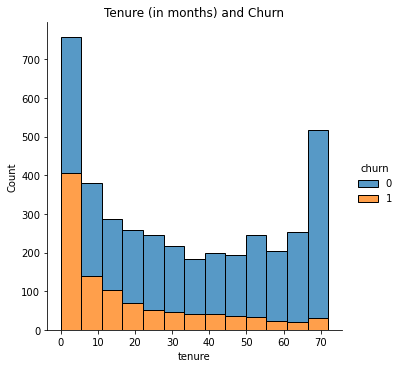

In [125]:
sns.displot(train, x="tenure",hue="churn", multiple='stack')
plt.title('Tenure (in months) and Churn')

Takeaways: 
 - Churn decreases as tenure increases. 
 - Reasonable, you'll stay with a company longer if you're happy with them.
 - Familiarity is a motive to stay.
 - Most customers churn within 0-10 months. 
 - Exponential decrease shape.

<br>

<br>

# Modeling

In [129]:
#we prepared the data earlier with the prep_telco_churn function. 
train.shape, validate.shape, test.shape

((3943, 27), (1691, 27), (1409, 27))

In [ ]:
# Let's begin by establishing a baseline accuracy. 

In [8]:
#x_cols are the features I'm focusing on to predict whether a customer churns or not. 
#y_col is our target
x_col = ['fiber_optic', 'electronic_check','tenure', 'two_year', 'monthly']
y_col = 'churn'

In [96]:
#splitting our data based on our features
X_train, y_train = train[x_col], train[y_col]

X_validate, y_validate = validate[x_col], validate[y_col]

X_test, y_test = test[x_col], test[y_col]

In [97]:
y_train.value_counts()

0    2897
1    1046
Name: churn, dtype: int64

In [35]:
#Since I can see most customers stayed, I will set my churn prediction to 0 for everyone. 
train['baseline_prediction'] = 0
round(accuracy_score(train.churn, train.baseline_prediction),2)

0.73

In [36]:
baseline_score = round(accuracy_score(train.churn, train.baseline_prediction),2)
print(f'Our baseline score is {baseline_score}')

Our baseline score is 0.73


<br>

Predictions end up 4 different ways:
 - TP: True Positive. We predicted the customer would stay & they did.
 - TN: True Negative. We predicted the customer would leave & they did.
 - FP: False Positive. We predicted the customer would stay & they didn't.
 - FN: False Negative. We predicted the customer would leave & they didn't.
    

In [143]:
#I am looking to optimize recall, because we want to maximize the number of actually positive cases we catch.
#In our case, let's say a positive case is a customer staying, because that's a good thing!
# If we can predict which ones will stay, we can focus on the ones that may leave.

## Decision Tree Model

In [86]:
tree = DecisionTreeClassifier(max_leaf_nodes=15, max_depth=5)

In [87]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15)

In [88]:
print(f'training score: {tree.score(X_train, y_train):.2%}')
print(f'validate score: {tree.score(X_validate, y_validate):.2%}')

training score: 79.99%
validate score: 78.30%


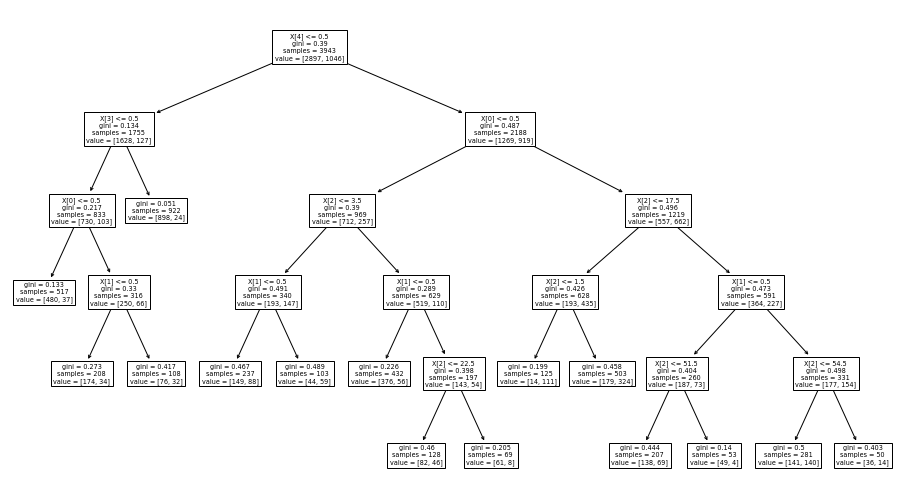

In [89]:
plt.figure(figsize=(16,9))
plot_tree(tree)
plt.show()

In [90]:
y_pred = tree.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2897
           1       0.68      0.47      0.56      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.70      0.71      3943
weighted avg       0.79      0.80      0.79      3943



In [91]:
print('Scores for Decision Tree!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0),2)}')

Scores for Decision Tree!
---------------------------
Baseline score is 0.73
accuracy score is 0.8
precision score is 0.83
recall score is 0.92


In [38]:
#Our accuracy is better than our baseline score, and we have a pretty good recall.

<br>

# Logistic Regression

In [39]:
logit = LogisticRegression(C= 10, random_state =123)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print(f'training score: {logit.score(X_train, y_train):.2%}')
print(f'validate score: {logit.score(X_validate, y_validate):.2%}')

training score: 79.61%
validate score: 78.89%


In [41]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      2897
           1       0.65      0.50      0.57      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.70      0.72      3943
weighted avg       0.78      0.80      0.79      3943



In [40]:
print('Scores for Logistic Regression!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0),2)}')

Scores for Logistic Regression!
---------------------------
Baseline score is 0.73
accuracy score is 0.8
precision score is 0.83
recall score is 0.9


In [42]:
#Our accuracy is better than our baseline score, and we have a pretty good recall here too.

<br>

## KNN 

In [43]:
#I saved my favorite for last 

In [78]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [79]:
print(f'training score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')

training score: 78.95%
validate score: 76.17%


In [80]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      2897
           1       0.65      0.50      0.57      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.70      0.72      3943
weighted avg       0.78      0.80      0.79      3943



In [100]:
actual_test = y_test
predicted_test = tree.predict(X_test)
print(classification_report(actual_test, predicted_test))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1035
           1       0.68      0.44      0.54       374

    accuracy                           0.80      1409
   macro avg       0.75      0.68      0.70      1409
weighted avg       0.78      0.80      0.78      1409

